In [78]:
# tested with pytorch 1.4
import torchvision
import torch
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
import torch.nn.functional as F
import time
import sklearn.cluster
import itertools
from scipy.stats import norm
import scipy.integrate as integrate
import scipy.interpolate as interpolate

use_gpu = True  # use GPU or not
latent_size = 3  # dimension of latent variable. Should be much smaller than the image size
learning_rate = 0.001
train_batch_size = 32   # size of traning batch
data_dir = '/tmp'
data_size = 28*28 # size of mnist image
encoder_hidden_size = latent_size*2
decoder_hidden_size = latent_size*2
max_epochs = 10
opt = 'adam'  # adam or rms
prior_memory = 1000 # number of mean and variance to keep

In [79]:
# Load mnist data
train_data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=True, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
                        batch_size=train_batch_size, shuffle=True)

test_data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=False, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor()
                         ])),
                        batch_size=10000, shuffle=True)


In [80]:
class Encode(nn.Module):
    # Encode image to latent variable
    # The neural network actually learns the means and variance of normal distributions of the latent variable
    # One mean and one variance per component of latent variable.
    def __init__(self, data_size, latent_size, hidden_size):
        super(Encode, self).__init__()
        self.layer1 = nn.Linear(data_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)     
        self.layer3 = nn.Linear(hidden_size, 2*latent_size) # *2 for mean and variance
        
    def forward(self, image):
        # return mean and variance of latent variable
        x = self.layer1(image)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        z_mean, z_variance = x[:,0:latent_size], x[:,latent_size:2*latent_size]
        z_variance = F.softplus(z_variance)  # make sure it is non-negative because need to take log later
        return z_mean, z_variance        

In [81]:
def labelsAccuracy(labels, accTable):
    assert len(np.unique(labels)) == len(labels)
    acc = 0.
    for i,l in enumerate(labels):
        acc += accTable[i][l]
    return acc

def kmean_acc(z, labels):
    '''
    # Return unsupervised classification accraucy by k-mean clustering
    # z: variable to be clustered
    # label: truth label
    '''
    kmeans = sklearn.cluster.KMeans(n_clusters=10, random_state=0).fit(z.detach().cpu())
    # generate accuracy table
    labelsT = np.unique(labels) # truth label
    labelsK = np.unique(kmeans.labels_) # kmean label
    maxLabels = []
    accTable = []
    for j in labelsK:
        acc = []
        for t in labelsT:
            # generate table, only look at one class
            # substitute one kmean label with truth label, set every else as invalid 
            table = dict()
            for k in labelsK:
                if k == j:
                    table[k] = t
                else:
                    table[k] = -1
            # calculate accuracy        
            l = np.vectorize(table.get)(kmeans.labels_)
            acc.append(float(sum(labels.numpy() == l))/len(labels))
        lmax = labelsT[np.argmax(acc)]
        #print(lmax, acc)
        maxLabels.append(lmax)
        accTable.append(acc)

   
    # check duplicates
    dupPos = []
    dupLabels = []
    for t in labelsT:
        match = np.array(maxLabels) == t
        if sum(match) > 1:
            pos = np.where(match)[0]
            for p in pos:
                dupPos.append(p)
            dupLabels.append(t)
    # add labels not used
    for l in set(labelsT).difference(np.unique(maxLabels)):
        dupLabels.append(l)
    #print(dupPos, dupLabels)

    accMax = 0.
    for p in itertools.permutations(dupLabels):
        l = maxLabels.copy()
        for pos,dl in zip(dupPos, p):
            l[pos] = dl
        acc  = labelsAccuracy(l, accTable)
        if acc > accMax:
            bestLabel = l.copy()
            accMax = acc   
    return accMax

#kmean_acc(z, label)

In [82]:
class Decode(nn.Module):
    # Decode latent variable to image
    def __init__(self, data_size, latent_size, hidden_size):
        super(Decode, self).__init__()
        
        # for auto-decoding
        self.layer1 = nn.Linear(latent_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, data_size) 
        self.logBernouli = torch.nn.BCEWithLogitsLoss(reduction = 'none')
    
    def network(self, z):
        # neutral network with 3 layers
        x = self.layer1(z)
        x = F.relu(x)
        x = self.layer2(x)
        x = F.relu(x)
        x = self.layer3(x)
        return x
    
    def forward(self, z, image):
        # return log likelihood of generated image
        x = self.network(z)
        return -self.logBernouli(x, image) # negative sign due to definition of the function
    
    def generateImage(self, z):
        # Generate image from latent variable
        x = self.network(z)
        return F.sigmoid(x).detach().cpu().numpy() > 0.5

In [83]:
def evaluate(test_data, encode):
    images, labels = next(iter(test_data))
    images=images.reshape([-1, data_size])  # resize each image to a linear 784-element array
    images =torch.bernoulli(images) # convert images to binary
    images = images.to(device)    
    z_mean, z_variance = encode(images)  # infer distribution of hidden variable
    z = z_mean + torch.randn(z_mean.shape, device=device)*torch.sqrt(z_variance) # reparameterization trick - generate z from distribution learned
    return kmean_acc(z, labels)
#evaluate(test_data,encode)

In [84]:
encode = Encode(data_size = data_size, 
                 latent_size = latent_size, 
                 hidden_size = encoder_hidden_size)

decode = Decode(data_size = data_size , 
                 latent_size = latent_size, 
                 hidden_size = decoder_hidden_size)

device = torch.device("cuda:0" if use_gpu else "cpu")
# set optimizer, pass network parameters to optimizer
encode.to(device)
decode.to(device)

if opt == 'adam':
    optimizer = torch.optim.Adam(list(encode.parameters()) + list(decode.parameters()), lr=learning_rate)
elif opt == 'rmsprop':
    optimizer = torch.optim.RMSprop(list(encode.parameters()) + list(decode.parameters()), lr=learning_rate, centered=True)
else:
    raise 'Unrecognized optimizer option %s'%opt


# Loop over epochs
i = 0
start_time = time.time()
print('%s:\t%s\t\t%s\t\t%s\t%s\t%s'%('epoch', 'reg', 'loglike', 'lowerBound', 'acc', 'time(s)'))
mean_mem = None
var_mem = None
for epoch in range(max_epochs):
    # Training
    reg_ep = 0
    loglike_ep = 0
    for images, label in train_data:
        
        # initialize
        encode.zero_grad()
        decode.zero_grad()
        images=images.reshape([-1, data_size])  # resize each image to a linear 784-element array
        images =torch.bernoulli(images) # convert images to binary
        images = images.to(device)
        
        # encode and decode 
        z_mean, z_variance = encode(images)  # infer distribution of hidden variable
        z = z_mean + torch.randn(z_mean.shape, device=device)*torch.sqrt(z_variance) # reparameterization trick - generate z from distribution learned
        loglike = decode(z, images) # generate image from hidden variable, compare result
        
        # calculate loss
        if mean_mem is None or epoch < 11:
            reg = 0.5*(1.+ torch.log(z_variance ) - z_mean**2 -z_variance).sum(1).mean()  # regularization term
        else:
            reg = torch.zeros(z_mean.shape)
            reg = reg.to(device)
            vm = torch.from_numpy(var_mem)
            #vm = torch.tensor(np.ones(var_mem.shape))
            vm = vm.to(device)
            mm = torch.from_numpy(mean_mem)
            #mm = torch.tensor(np.zeros(var_mem.shape))
            mm = mm.to(device)
            for i in range(z_mean.shape[0]):
                reg[i] = (0.5*(1.+torch.log(z_variance[i]/vm)  - ((z_mean[i]-mm)**2 + z_variance[i] )/vm ) ).mean(0)
            reg = reg.sum(1).mean()
            
            
        loglike =loglike.sum(1).mean()  # log likelihood term
        lowerBound = loglike+ reg
        loss = -lowerBound  # maximize lower bound
        
        # backprop
        loss.backward()
        optimizer.step()
                        
        i = i + 1
        reg_ep += reg
        loglike_ep += loglike
        if mean_mem is None:
            mean_mem = z_mean.detach().cpu().numpy()
            var_mem = z_variance.detach().cpu().numpy()
        else:
            mean_mem = np.concatenate( [mean_mem, z_mean.detach().cpu()] )
            var_mem = np.concatenate([var_mem, z_variance.detach().cpu()] )
        
        if mean_mem.shape[0] > prior_memory:
            mean_mem = mean_mem[-prior_memory-1:-1]
            var_mem = var_mem[-prior_memory-1:-1]
        
        
    if epoch%1 == 0:
        acc = evaluate(test_data,encode)
        print('%d:\t%1.2f\t%1.2f\t%1.2f\t%1.3f\t%1.1f'%(epoch, reg_ep, loglike_ep, reg_ep+loglike_ep, acc, time.time()-start_time))

epoch:	reg		loglike		lowerBound	acc	time(s)
0:	-6185.65	-429466.75	-435652.41	0.181	48.3
1:	-4385.55	-366148.16	-370533.72	0.165	87.1
2:	-3706.58	-360159.69	-363866.28	0.182	135.9
3:	-3542.61	-357187.78	-360730.38	0.197	175.4
4:	-3564.92	-354834.00	-358398.94	0.196	224.2
5:	-3665.11	-352978.09	-356643.22	0.197	264.7
6:	-3821.79	-350837.16	-354658.94	0.204	304.4
7:	-3904.93	-349517.12	-353422.06	0.189	343.6
8:	-3941.19	-349181.09	-353122.28	0.169	485.5
9:	-3978.09	-348952.19	-352930.28	0.189	524.9


### Autoencoding and decoded image

In [85]:
numSamples = 10000

In [86]:
data = torch.utils.data.DataLoader(
torchvision.datasets.MNIST(data_dir, train=True, download=True,
                         transform=torchvision.transforms.Compose([
                           torchvision.transforms.ToTensor(),
                           torchvision.transforms.Normalize(
                             (0.1307,), (0.3081,))
                         ])),
                        batch_size=numSamples, shuffle=True)
images, labels = iter(data).next()
images=images.reshape([-1, data_size])  # resize each image to a linear 784-element array
images =(images > 0.5).float() # convert images to binary
images = images.to(device)

In [87]:
# generate hidden variables z
z_mean, z_variance = encode(images)  # infer distribution of hidden variable
z = z_mean + torch.randn(z_mean.shape, device=device)*torch.sqrt(z_variance)  # reparameterization trick - generate z from distribution learned

0 [-0.03264585  0.01455938 -1.8361498 ]
1 [-0.03281027  0.04709043  1.3986782 ]
2 [ 0.04609313  0.03753014 -0.7438074 ]
3 [-0.05681195 -0.00220769 -0.32362044]
4 [ 0.04143748 -0.0014782  -0.13387504]
5 [-0.02027932 -0.03740186 -0.25053087]
6 [ 0.04777663 -0.04092097 -0.6990851 ]
7 [0.02219942 0.01624455 0.28228185]
8 [0.01354785 0.0081471  0.11854985]
9 [ 0.03781449 -0.00187044  0.20833197]


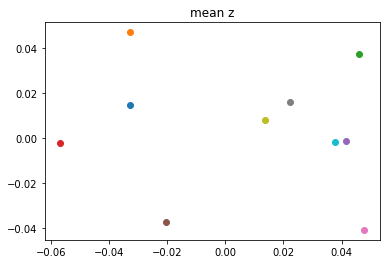

In [90]:
for l in range(10):
    meanz = z[labels == l].mean(0)
    meanz = meanz.detach().cpu().numpy()
    print(l, meanz)
    plt.plot(meanz[0], meanz[1], 'o')
    plt.title('mean z')
    

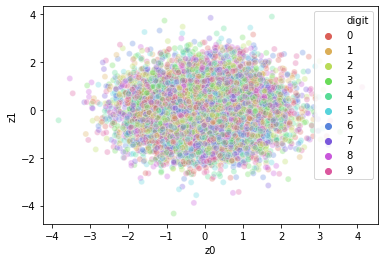

In [93]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
feat_cols = [ 'z'+str(i) for i in range(z.shape[1]) ]
df = pd.DataFrame(np.array(z.detach().cpu()) ,columns=feat_cols)
df['digit'] = labels
df['label'] = df['digit'].apply(lambda i: str(i))

sns.scatterplot(
    x="z0", y="z1",
    hue="digit",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

# for l in [0,1,2,3,]:
#     plt.plot(z.detach().cpu()[:,0], z.detach().cpu()[:,1], '.')

/home/wongc/anaconda3/envs/pytorch1.4/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


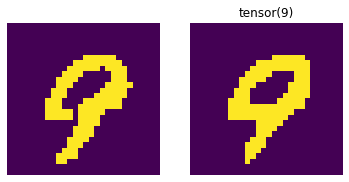

In [11]:
i = 20
fig, axs = plt.subplots(1, 2)
axs[0].imshow( images[i,:].reshape([28,28]).detach().cpu().numpy())
axs[1].imshow(decode.generateImage(z[i]).reshape([28, 28]))
axs[0].axis('off')
axs[1].axis('off')
plt.title(str(labels[i]) );

## generate more digits

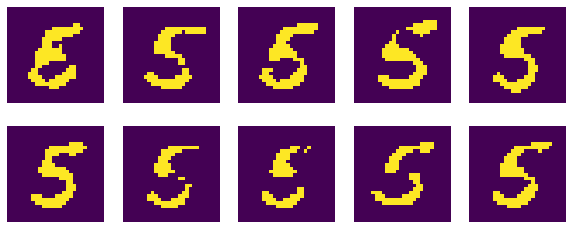

In [12]:
digit = 5
numSamples = 10
fig, axs = plt.subplots( int(numSamples/5), 5)
fig.set_figheight(4)
fig.set_figwidth(10)
z_digit_mean = z_mean[labels==digit]
z_digit_var = z_variance[labels==digit]
zz = z_digit_mean.mean(0) + torch.randn( (numSamples, z_digit_mean.shape[1]), device=device)*torch.sqrt(z_digit_var.mean(0))
for i in range(numSamples):
    img = decode.generateImage(zz[i]).reshape([28, 28])
    axs[int(i/5), int(i%5) ].imshow(img)
    axs[int(i/5), int(i%5) ].axis('off')

## Average and mixed digit

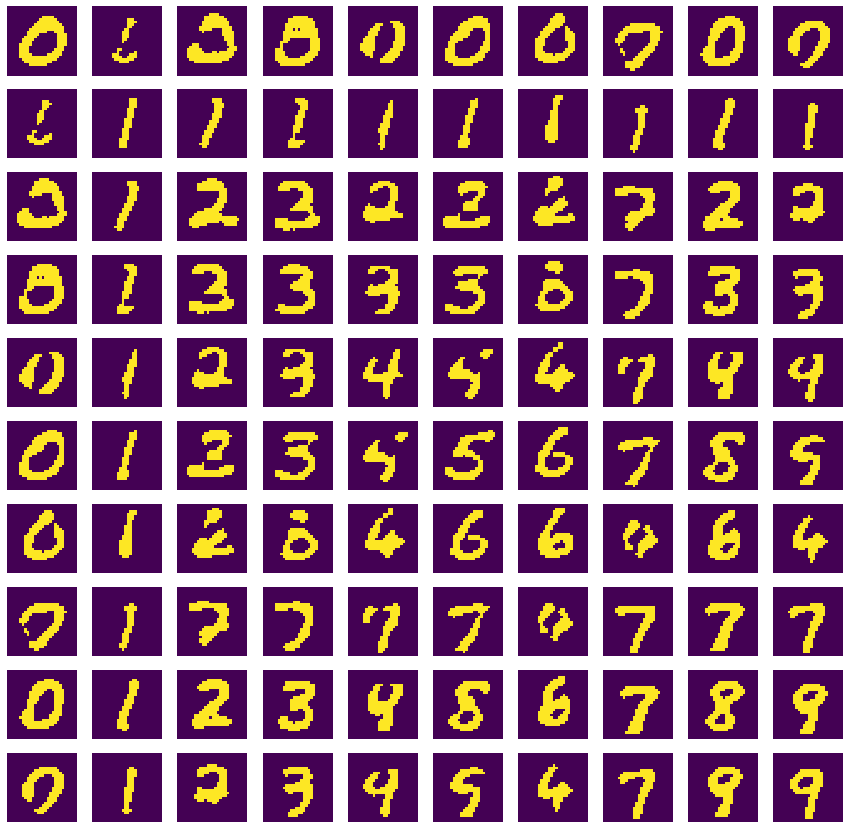

In [13]:
fig, axs = plt.subplots(10, 10)
fig.set_figheight(15)
fig.set_figwidth(15)
for digit1 in range(0, 10):
    for digit2 in range(0, 10):

        z1_average = z[labels == digit1].mean(0)
        z2_average = z[labels == digit2].mean(0)
        img = decode.generateImage(z1_average + z2_average).reshape([28,28])
        axs[digit1, digit2].imshow( img)
        axs[digit1, digit2].axis('off')
        #plt.title(str(digit1) + str(digit2) )

## Digit interpolation

/home/wongc/anaconda3/envs/pytorch1.4/lib/python3.8/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


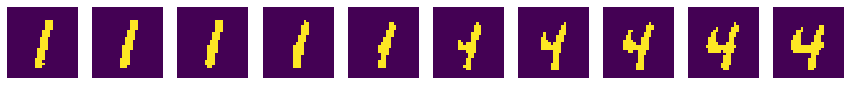

In [14]:
# interploation
digit1 = 1
digit2 = 4
fig, axs = plt.subplots(1, 10)
fig.set_figheight(1.5)
fig.set_figwidth(15)
z1_average = z[labels == digit1].mean(0).detach().cpu()
z2_average = z[labels == digit2].mean(0).detach().cpu()
from scipy.interpolate import interp1d
linfit = interp1d([0,9], np.vstack([z1_average, z2_average]), axis=0)

for i in range(10):
    z_int = torch.tensor(linfit(i))
    z_int = z_int.to(device) #.reshape([1, len(z_int)])
    z_int = z_int.float()
    img = decode.generateImage(z_int ).reshape([28,28])
    axs[i].imshow( img)
    axs[i].axis('off')

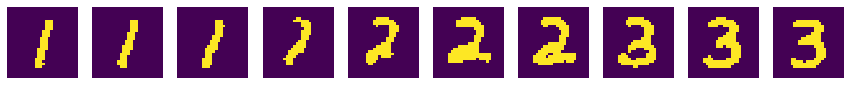

In [15]:
# interploation
digit1 = 1
digit2 = 2
digit3 = 3
fig, axs = plt.subplots(1, 10)
fig.set_figheight(1.5)
fig.set_figwidth(15)
z1_average = z[labels == digit1].mean(0).detach().cpu()
z2_average = z[labels == digit2].mean(0).detach().cpu()
z3_average = z[labels == digit3].mean(0).detach().cpu()
from scipy.interpolate import interp1d
linfit = interp1d([0,5,9], np.vstack([z1_average, z2_average, z3_average]), axis=0)

for i in range(10):
    z_int = torch.tensor(linfit(i))
    z_int = z_int.to(device) #.reshape([1, len(z_int)])
    z_int = z_int.float()
    img = decode.generateImage(z_int ).reshape([28,28])
    axs[i].imshow( img)
    axs[i].axis('off')

### Visualize latten variable

In [51]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
feat_cols = [ 'z'+str(i) for i in range(z.shape[1]) ]
df = pd.DataFrame(np.array(z.detach().cpu()) ,columns=feat_cols)
df['digit'] = labels
df['label'] = df['digit'].apply(lambda i: str(i))
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(df)
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="digit",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=0.3
)

NameError: name 'labels' is not defined